# Dealing with Correlated data

In this notebook we will calculate the first and the second moment of an analytical blackbox in two cases:
- Independent Samples
- Correlated Samles

The problem is four-dimensional: the uncertain inputs are:
- Inlet and Outlet Total Temperatures  ($T_1$, $T_2$)
- Inlet and Outlet Total Pressures ($P_1$, $P_2$).

The blackbox is the thermal efficiency of a Gas Turbine; the mean values of the uncertain parameters are typical of a LPT.

## 1) Independent Data
Modules to be imported:

In [2]:
from equadratures import *
import numpy as np

In the lines below the turbine efficiency has been defined: the uncertain values of the variables $T_1$, $T_2$, $P_1$, $P_2$ are assigned to the values assumed by the Input X.

In [3]:
def efficiency(x):
    t1 = x[0]
    t2 = x[1]
    p1 = x[2]
    p2 = x[3]
    gamma = 1.41
    eta = (t1 - t2) / (t1 * (1 - (p2/p1)**( (gamma-1.)/(gamma) ) ) )
    return eta * 100.0

The mean values of the Total Temperatures and Pressures have to be specified (see slides):

In [4]:
# Mean values
T01 = 1100. # Kelvin
T02 = 800. # Kelvin
P01 = 90.0 # psi
P02 = 29.0 # psi

The statistical distribution which better describes the uncertainties related to the inputs are **truncated-gaussians**. Since a **truncated-gaussian** is constructed from a Gaussian, the mean and the variance have to be specied (variables ``shape_parameter_A`` and ``shape_parameter_B`` respectively). The domain of the samples is a closed set between the ``lower`` and ``upper``.

In [44]:
# Define parameters 
t1 = Parameter(order=3, distribution='truncated-gaussian', shape_parameter_A=T01, shape_parameter_B=(0.01*T01)**2, lower=0.95*T01, upper=1.10*T01)
t2 = Parameter(order=3, distribution='truncated-gaussian', shape_parameter_A=T02, shape_parameter_B=(0.01*T02)**2, lower=0.95*T02, upper=1.10*T02)
p1 = Parameter(order=3, distribution='truncated-gaussian', shape_parameter_A=P01, shape_parameter_B=(0.01*P01)**2, lower=0.95*P01, upper=1.10*P01)
p2 = Parameter(order=3, distribution='truncated-gaussian', shape_parameter_A=P02, shape_parameter_B=(0.01*P02)**2, lower=0.95*P02, upper=1.10*P02)

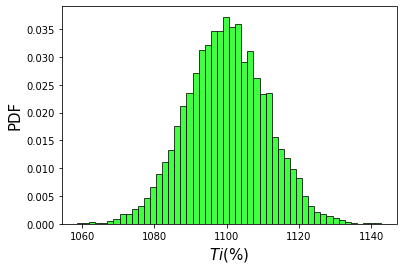

In [45]:
# PDF of s2 is plotted here
import matplotlib.pyplot as plt
z2_samples = t1.get_samples(9000)
n, bins, patches = plt.hist(z2_samples, 50, density=True, facecolor='lime', alpha=0.75, edgecolor='k')
plt.xlabel(r'$Ti (\%)$', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.show()

Set a ``tensor-grid`` ``Basis`` and a ``Poly`` with ``numerical-integration``.

In [46]:
myBasis = Basis('tensor-grid')
myPoly = Poly([t1, t2, p1, p2], basis=myBasis, method='numerical-integration')
myPoly.set_model(efficiency)

The first and and the second moment of the efficiency can now be calculated.

In [47]:
mean, var = myPoly.get_mean_and_variance()

In [48]:
print(mean, np.sqrt(var))

97.18759840021818 3.8079977767232047


### 2) Correlated Data

Let's define a correlation matrix $R$ which describes a quite negative strong correlation between Temperatures (the Pearson coefficient is equal to $0.9$) and between Pressures (the Pearson coefficient is $0.8$).

In [49]:
R = np.array([[1.0, 0.9, 0.0, 0.0],
              [0.9, 1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.8],
              [0.0, 0.0, 0.8, 1.0]])

The instance of the ``Correlation`` class needs the set of input Parameters and the Correlation Matrix previously defined.

In [50]:
corr = Correlations(myPoly, R)

The next step is the calcultion of the coefficients for the new case, followed by the transformation of the inpendent points to a new *physical* space with correlation.

In [51]:
corr_efficiency = corr.set_model(efficiency)

In [52]:
corrpoly = corr.get_transformed_poly()

Now we can evaluate the mean and the variance for the case in which the inputs of the blackbox are correlated.

In [53]:
mean, var = corrpoly.get_mean_and_variance()
print(mean, np.sqrt(var))

97.20052089989314 1.2626529983145514


### Graphical comparison of correlated Data and independent one

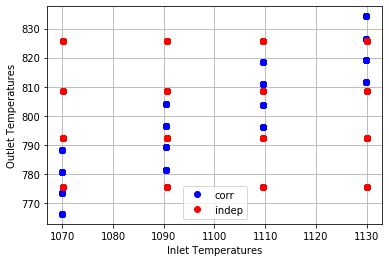

In [20]:
import matplotlib.pyplot as plt

c_samples = corr.get_points()
i_samples = myPoly.get_points()
#fig = plt.figure()
# temperatures
plt.grid()
plt.plot(c_samples[:,0], c_samples[:,1], 'o', c= 'blue', label='corr')
plt.plot(i_samples[:,0], i_samples[:,1], 'o', c = 'red', label='indep')
plt.legend()
plt.xlabel('Inlet Temperatures')
plt.ylabel('Outlet Temperatures')
plt.show()